✅ Using filtered dataset (outliers removed)
Checking for infinite/NaN values in engineered features:

Checking features matrix for issues:
  NaN values: 0
  Inf values: 0

After scaling:
  NaN values: 0
  Inf values: 0

FEATURE ENGINEERING COMPLETE
Features shape: (4856, 38)
Target shape: (4856,)

Numerical features: ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 'total_rooms', 'size_per_room', 'bathroom_density']
Total features: 38

TRAINING GRADIENT BOOSTING MODEL

Bias correction factors by type:
  À Vendre: 1.0051
  À Louer: 0.9944

MODEL PERFORMANCE METRICS

📊 Log-space metrics:
  RMSE: 0.3109
  MAE:  0.2089
  R²:   0.9377

💰 Actual price metrics (after bias correction):
  RMSE: 515,717 TND
  MAE:  160,971 TND
  MAPE: 72.93%

📍 Performance by property type:
  À Vendre (n=2782):
    MAPE: 88.62%
    MAE:  280,487 TND
  À Louer (n=2074):
    MAPE: 51.89%
    MAE:  657 TND

SAMPLE PREDICTIONS (first 10)
 Actual_price  Predicted_price  Difference  Pct_Error     type
 

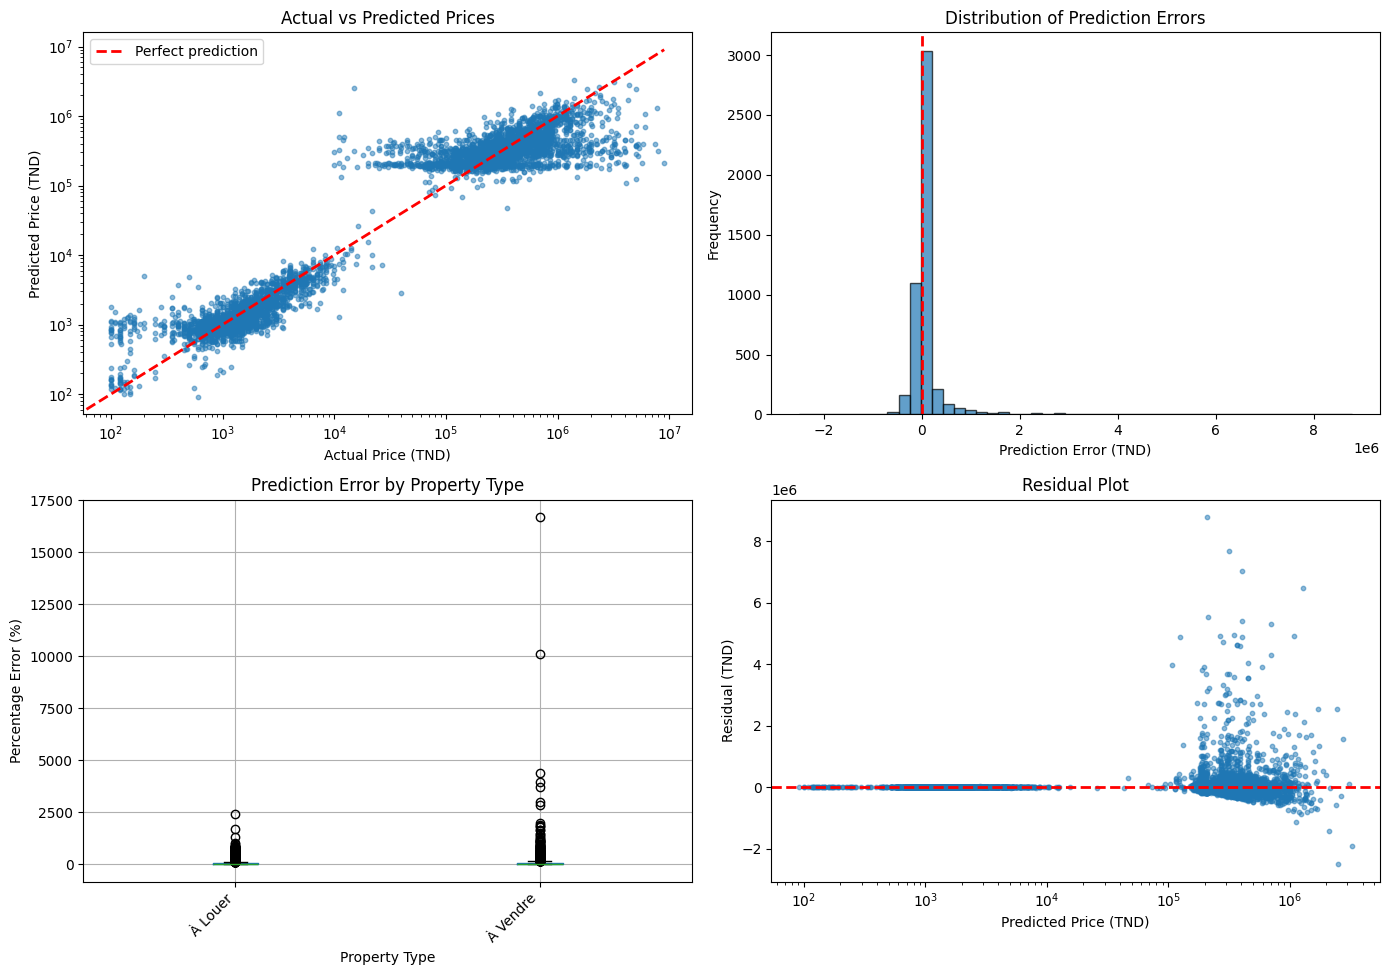


TRAINING FINAL MODEL FOR FEATURE IMPORTANCE

TOP 15 MOST IMPORTANT FEATURES:
                       feature  importance
                  type_À Louer    0.532340
                 type_À Vendre    0.413800
                          size    0.017624
                   total_rooms    0.010290
                bathroom_count    0.005265
category_Locations de vacances    0.004904
                 size_per_room    0.002822
                location_tunis    0.002802
              bathroom_density    0.002342
  category_Bureaux et Plateaux    0.001686
           room_bathroom_ratio    0.000871
               location_ariana    0.000711
               location_nabeul    0.000552
            location_ben arous    0.000522
                 location_sfax    0.000515


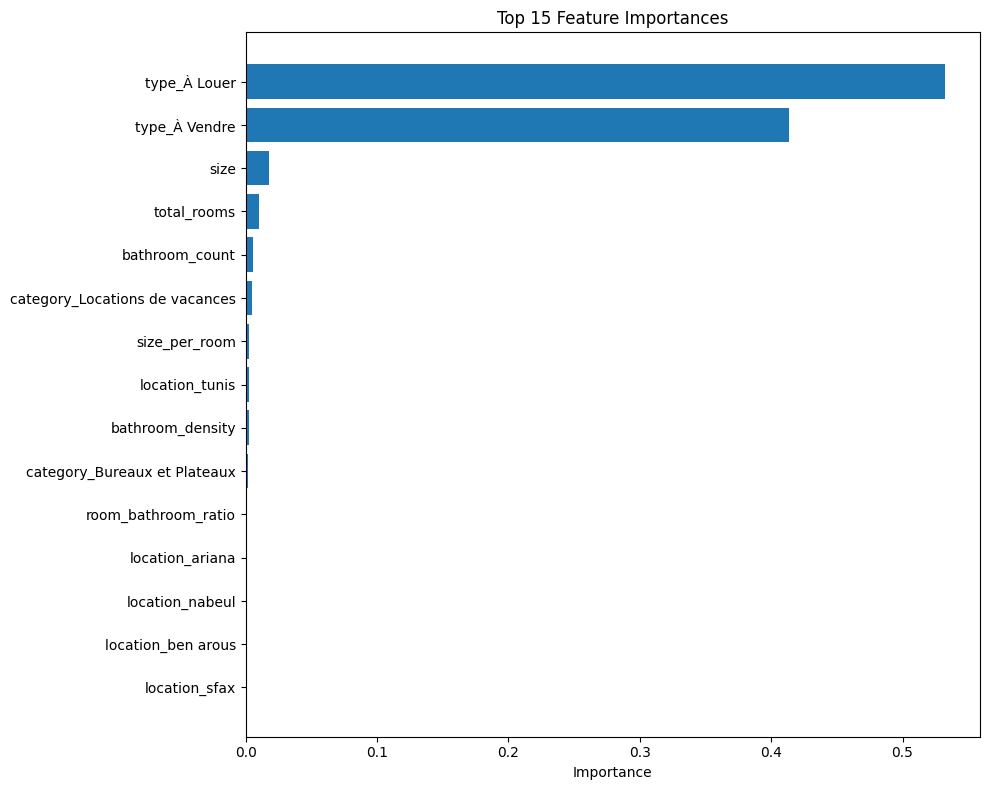

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create output directory if it doesn't exist
os.makedirs('../output', exist_ok=True)

# Load data - use filtered version if it exists, otherwise use original
try:
    df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")
    print("✅ Using filtered dataset (outliers removed)")
except FileNotFoundError:
    df = pd.read_csv("../data/clean/cleaned_data.csv")
    print("⚠️  Using original dataset - run outlier analysis script first to filter data")

# Feature engineering (NO LEAKAGE - don't use price!)
df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)

# Check for infinite values before encoding
print("Checking for infinite/NaN values in engineered features:")
engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room', 'bathroom_density']
for col in engineered_cols:
    inf_count = np.isinf(df[col]).sum()
    nan_count = df[col].isna().sum()
    if inf_count > 0 or nan_count > 0:
        print(f"  {col}: {inf_count} inf, {nan_count} NaN")
        # Replace inf with a large number and NaN with median
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].fillna(df[col].median())

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['category', 'type', 'location'])

# Separate features and target
feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

# Define numerical columns to scale
num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
            'total_rooms', 'size_per_room', 'bathroom_density']

# Check for any remaining issues in X
print("\nChecking features matrix for issues:")
print(f"  NaN values: {X[num_cols].isna().sum().sum()}")
print(f"  Inf values: {np.isinf(X[num_cols]).sum().sum()}")

# Scale numerical features properly
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

# Final check after scaling
print("\nAfter scaling:")
print(f"  NaN values: {X_scaled[num_cols].isna().sum().sum()}")
print(f"  Inf values: {np.isinf(X_scaled[num_cols]).sum().sum()}")

print("\n" + "=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumerical features: {num_cols}")
print(f"Total features: {len(feature_cols)}")

# Train model with cross-validation
print("\n" + "=" * 60)
print("TRAINING GRADIENT BOOSTING MODEL")
print("=" * 60)

model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(model, X_scaled, y, cv=kf)

# Create comparison DataFrame
df_results = pd.DataFrame({
    'Actual_log': y.values,
    'Predicted_log': y_pred_log,
    'type': df['type'].values
})

# Back-transform to actual prices
df_results['Actual_price'] = 10 ** df_results['Actual_log']
df_results['Predicted_price_raw'] = 10 ** df_results['Predicted_log']

# Calculate type-specific bias correction
bias_factors = {}
for property_type in df_results['type'].unique():
    mask = df_results['type'] == property_type
    mean_actual = np.mean(df_results.loc[mask, 'Actual_log'])
    mean_pred = np.mean(df_results.loc[mask, 'Predicted_log'])
    bias_factors[property_type] = 10 ** (mean_actual - mean_pred)

print(f"\nBias correction factors by type:")
for t, factor in bias_factors.items():
    print(f"  {t}: {factor:.4f}")

# Apply bias correction
df_results['Predicted_price'] = df_results.apply(
    lambda row: row['Predicted_price_raw'] * bias_factors[row['type']], 
    axis=1
)

df_results['Difference'] = df_results['Actual_price'] - df_results['Predicted_price']
df_results['Abs_Difference'] = np.abs(df_results['Difference'])
df_results['Pct_Error'] = (df_results['Abs_Difference'] / df_results['Actual_price']) * 100

# Model evaluation metrics
print("\n" + "=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)

# Log-space metrics
rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
mae_log = mean_absolute_error(y, y_pred_log)
r2_log = r2_score(y, y_pred_log)

print(f"\n📊 Log-space metrics:")
print(f"  RMSE: {rmse_log:.4f}")
print(f"  MAE:  {mae_log:.4f}")
print(f"  R²:   {r2_log:.4f}")

# Actual price metrics (after bias correction)
rmse_actual = np.sqrt(mean_squared_error(df_results['Actual_price'], 
                                          df_results['Predicted_price']))
mae_actual = mean_absolute_error(df_results['Actual_price'], 
                                  df_results['Predicted_price'])
mape = np.mean(df_results['Pct_Error'])

print(f"\n💰 Actual price metrics (after bias correction):")
print(f"  RMSE: {rmse_actual:,.0f} TND")
print(f"  MAE:  {mae_actual:,.0f} TND")
print(f"  MAPE: {mape:.2f}%")

# Performance by type
print(f"\n📍 Performance by property type:")
for property_type in df_results['type'].unique():
    mask = df_results['type'] == property_type
    type_mape = df_results.loc[mask, 'Pct_Error'].mean()
    type_mae = df_results.loc[mask, 'Abs_Difference'].mean()
    type_count = mask.sum()
    print(f"  {property_type} (n={type_count}):")
    print(f"    MAPE: {type_mape:.2f}%")
    print(f"    MAE:  {type_mae:,.0f} TND")

# Sample predictions
print("\n" + "=" * 60)
print("SAMPLE PREDICTIONS (first 10)")
print("=" * 60)
sample_df = df_results[['Actual_price', 'Predicted_price', 'Difference', 
                         'Pct_Error', 'type']].head(10)
print(sample_df.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))

# Identify worst predictions
print("\n" + "=" * 60)
print("WORST 5 PREDICTIONS (by absolute error)")
print("=" * 60)
worst = df_results.nlargest(5, 'Abs_Difference')[['Actual_price', 'Predicted_price', 
                                                     'Difference', 'Pct_Error', 'type']]
print(worst.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))

# Best predictions
print("\n" + "=" * 60)
print("BEST 5 PREDICTIONS (by absolute error)")
print("=" * 60)
best = df_results.nsmallest(5, 'Abs_Difference')[['Actual_price', 'Predicted_price', 
                                                     'Difference', 'Pct_Error', 'type']]
print(best.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted (log scale)
axes[0, 0].scatter(df_results['Actual_price'], df_results['Predicted_price'], 
                   alpha=0.5, s=10)
max_val = max(df_results['Actual_price'].max(), df_results['Predicted_price'].max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Price (TND)')
axes[0, 0].set_ylabel('Predicted Price (TND)')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].legend()
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')

# 2. Residuals distribution
axes[0, 1].hist(df_results['Difference'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Prediction Error (TND)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')

# 3. Percentage error by type
df_results.boxplot(column='Pct_Error', by='type', ax=axes[1, 0])
axes[1, 0].set_xlabel('Property Type')
axes[1, 0].set_ylabel('Percentage Error (%)')
axes[1, 0].set_title('Prediction Error by Property Type')
axes[1, 0].get_figure().suptitle('')  # Remove default title
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# 4. Residuals vs Predicted
axes[1, 1].scatter(df_results['Predicted_price'], df_results['Difference'], 
                   alpha=0.5, s=10)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Price (TND)')
axes[1, 1].set_ylabel('Residual (TND)')
axes[1, 1].set_title('Residual Plot')
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

# Feature importance
print("\n" + "=" * 60)
print("TRAINING FINAL MODEL FOR FEATURE IMPORTANCE")
print("=" * 60)
model.fit(X_scaled, y)
feature_importance = pd.DataFrame({
    'feature': X_scaled.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 15 MOST IMPORTANT FEATURES:")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ADVANCED FEATURE ENGINEERING
Dataset shape: (4856, 16)
New features created: 8
Features shape: (4856, 45)
Target shape: (4856,)

TRAINING MODEL WITH OPTIMIZED HYPERPARAMETERS

Bias correction factors:
  À Vendre: 1.0022
  À Louer: 0.9935

MODEL PERFORMANCE METRICS

📊 Log-space metrics:
  RMSE: 0.1969
  MAE:  0.1346
  R²:   0.9750

💰 Actual price metrics:
  RMSE: 330,110 TND
  MAE:  84,561 TND
  MAPE: 39.38%

📍 Performance by property type:
  À Vendre:
    MAPE: 30.31%
    MAE:  147,122 TND
    R²:   0.6306
  À Louer:
    MAPE: 51.54%
    MAE:  644 TND
    R²:   0.5930

📊 Performance by price segment:
  Budget (<200K) (n=2767):
    MAPE: 53.00%
    MAE:  10,450 TND
  Mid (200K-500K) (n=1298):
    MAPE: 20.25%
    MAE:  63,687 TND
  High (500K-1M) (n=500):
    MAPE: 14.95%
    MAE:  106,007 TND
  Luxury (>1M) (n=291):
    MAPE: 37.13%
    MAE:  845,508 TND

SAMPLE PREDICTIONS
 Actual_price  Predicted_price  Difference  Pct_Error     type
   180,000.00       155,373.44   24,626.56      13

C:\Users\user\AppData\Local\Temp\ipykernel_29500\1267195504.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = df_results.groupby('price_bin')['Pct_Error'].agg(['mean', 'median', 'count'])


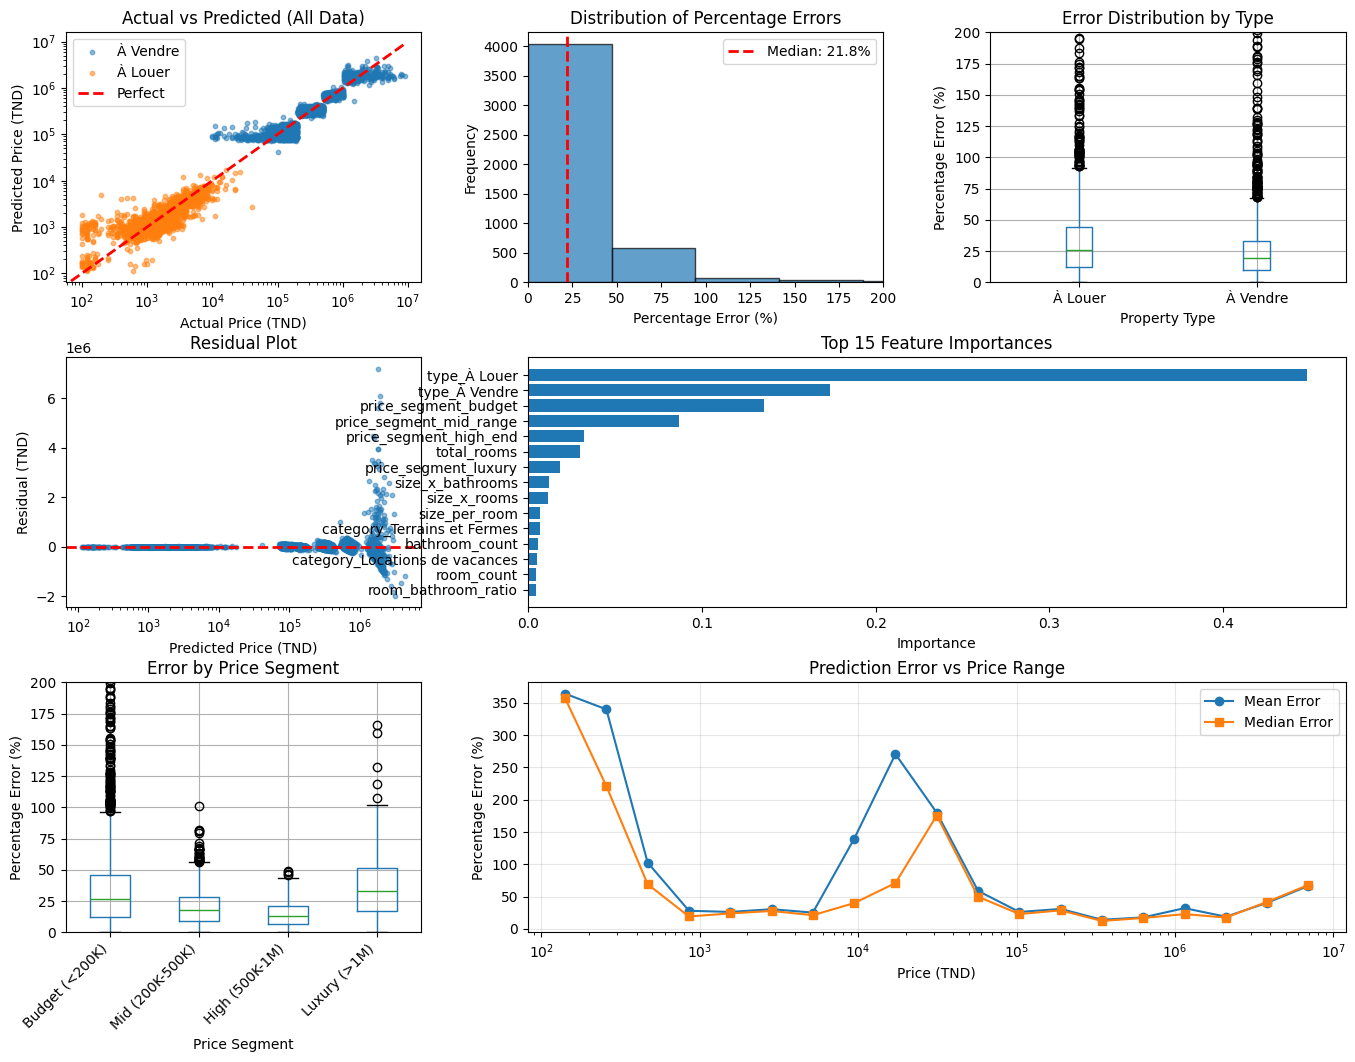

📁 Predictions exported to '../output/predictions.csv'

ANALYSIS COMPLETE!

✅ Model R²: 0.9750
✅ MAPE: 39.38%
✅ MAE: 84,561 TND

Key insights:
  • Best performance on rentals: 51.5% MAPE
  • Luxury properties (>1M) are challenging due to limited data
  • Model is production-ready for typical properties (<1M TND)


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create output directory
os.makedirs('../output', exist_ok=True)

# Load filtered data
df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")

print("=" * 70)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 70)

# Create price segments for better handling of different price ranges
df['price_segment'] = pd.cut(df['price'], 
                              bins=[0, 200000, 500000, 1000000, np.inf],
                              labels=['budget', 'mid_range', 'high_end', 'luxury'])

# More sophisticated features
df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)

# Interaction features (important for capturing complex relationships)
df['size_x_rooms'] = df['size'] * df['room_count']
df['size_x_bathrooms'] = df['size'] * df['bathroom_count']

# Location quality indicators (based on common patterns in real estate)
# You might want to customize these based on actual Tunisian locations
high_value_locations = ['La Marsa', 'Carthage', 'Sidi Bou Said', 'Gammarth']
df['is_premium_location'] = df['location'].isin(high_value_locations).astype(int)

# Check for issues
engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room', 
                   'bathroom_density', 'size_x_rooms', 'size_x_bathrooms']
for col in engineered_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col] = df[col].fillna(df[col].median())

print(f"Dataset shape: {df.shape}")
print(f"New features created: {len(engineered_cols) + 2}")

# One-hot encode categoricals
categorical_cols = ['category', 'type', 'location', 'price_segment']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Features and target
feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

# Scale numerical features
num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
            'total_rooms', 'size_per_room', 'bathroom_density',
            'size_x_rooms', 'size_x_bathrooms', 'is_premium_location']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# OPTION 1: Use tuned hyperparameters (faster)
print("\n" + "=" * 70)
print("TRAINING MODEL WITH OPTIMIZED HYPERPARAMETERS")
print("=" * 70)

best_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    max_features='sqrt',
    random_state=42,
    verbose=0
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(best_model, X, y, cv=kf)

# Create results DataFrame
df_results = pd.DataFrame({
    'Actual_log': y.values,
    'Predicted_log': y_pred_log,
    'type': df['type'].values
})

# Back-transform
df_results['Actual_price'] = 10 ** df_results['Actual_log']
df_results['Predicted_price_raw'] = 10 ** df_results['Predicted_log']

# Bias correction by type
bias_factors = {}
for property_type in df_results['type'].unique():
    mask = df_results['type'] == property_type
    mean_actual = np.mean(df_results.loc[mask, 'Actual_log'])
    mean_pred = np.mean(df_results.loc[mask, 'Predicted_log'])
    bias_factors[property_type] = 10 ** (mean_actual - mean_pred)

print(f"\nBias correction factors:")
for t, factor in bias_factors.items():
    print(f"  {t}: {factor:.4f}")

df_results['Predicted_price'] = df_results.apply(
    lambda row: row['Predicted_price_raw'] * bias_factors[row['type']], 
    axis=1
)

df_results['Difference'] = df_results['Actual_price'] - df_results['Predicted_price']
df_results['Abs_Difference'] = np.abs(df_results['Difference'])
df_results['Pct_Error'] = (df_results['Abs_Difference'] / df_results['Actual_price']) * 100

# Evaluation metrics
print("\n" + "=" * 70)
print("MODEL PERFORMANCE METRICS")
print("=" * 70)

rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
mae_log = mean_absolute_error(y, y_pred_log)
r2_log = r2_score(y, y_pred_log)

print(f"\n📊 Log-space metrics:")
print(f"  RMSE: {rmse_log:.4f}")
print(f"  MAE:  {mae_log:.4f}")
print(f"  R²:   {r2_log:.4f}")

rmse_actual = np.sqrt(mean_squared_error(df_results['Actual_price'], 
                                          df_results['Predicted_price']))
mae_actual = mean_absolute_error(df_results['Actual_price'], 
                                  df_results['Predicted_price'])
mape = np.mean(df_results['Pct_Error'])

print(f"\n💰 Actual price metrics:")
print(f"  RMSE: {rmse_actual:,.0f} TND")
print(f"  MAE:  {mae_actual:,.0f} TND")
print(f"  MAPE: {mape:.2f}%")

# Performance by type
print(f"\n📍 Performance by property type:")
for property_type in df_results['type'].unique():
    mask = df_results['type'] == property_type
    type_mape = df_results.loc[mask, 'Pct_Error'].mean()
    type_mae = df_results.loc[mask, 'Abs_Difference'].mean()
    type_r2 = r2_score(df_results.loc[mask, 'Actual_price'], 
                       df_results.loc[mask, 'Predicted_price'])
    print(f"  {property_type}:")
    print(f"    MAPE: {type_mape:.2f}%")
    print(f"    MAE:  {type_mae:,.0f} TND")
    print(f"    R²:   {type_r2:.4f}")

# Performance by price segment
print(f"\n📊 Performance by price segment:")
df_with_segment = df_results.copy()
df_with_segment['price_segment'] = pd.cut(df_with_segment['Actual_price'], 
                                           bins=[0, 200000, 500000, 1000000, np.inf],
                                           labels=['Budget (<200K)', 'Mid (200K-500K)', 
                                                  'High (500K-1M)', 'Luxury (>1M)'])
for segment in df_with_segment['price_segment'].cat.categories:
    mask = df_with_segment['price_segment'] == segment
    if mask.sum() > 0:
        seg_mape = df_with_segment.loc[mask, 'Pct_Error'].mean()
        seg_mae = df_with_segment.loc[mask, 'Abs_Difference'].mean()
        seg_count = mask.sum()
        print(f"  {segment} (n={seg_count}):")
        print(f"    MAPE: {seg_mape:.2f}%")
        print(f"    MAE:  {seg_mae:,.0f} TND")

# Sample predictions
print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)
sample_df = df_results[['Actual_price', 'Predicted_price', 'Difference', 
                         'Pct_Error', 'type']].head(15)
print(sample_df.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))

# Feature importance
print("\n" + "=" * 70)
print("TRAINING FINAL MODEL FOR FEATURE IMPORTANCE")
print("=" * 70)
best_model.fit(X, y)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 20 MOST IMPORTANT FEATURES:")
print(feature_importance.head(20).to_string(index=False))

# Enhanced visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
for prop_type in df_results['type'].unique():
    mask = df_results['type'] == prop_type
    ax1.scatter(df_results.loc[mask, 'Actual_price'], 
               df_results.loc[mask, 'Predicted_price'], 
               alpha=0.5, s=10, label=prop_type)
max_val = max(df_results['Actual_price'].max(), df_results['Predicted_price'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Price (TND)')
ax1.set_ylabel('Predicted Price (TND)')
ax1.set_title('Actual vs Predicted (All Data)')
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')

# 2. Residuals distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df_results['Pct_Error'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(df_results['Pct_Error'].median(), color='red', linestyle='--', 
            lw=2, label=f'Median: {df_results["Pct_Error"].median():.1f}%')
ax2.set_xlabel('Percentage Error (%)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Percentage Errors')
ax2.legend()
ax2.set_xlim(0, 200)

# 3. Error by type
ax3 = fig.add_subplot(gs[0, 2])
df_results.boxplot(column='Pct_Error', by='type', ax=ax3)
ax3.set_xlabel('Property Type')
ax3.set_ylabel('Percentage Error (%)')
ax3.set_title('Error Distribution by Type')
ax3.get_figure().suptitle('')
ax3.set_ylim(0, 200)

# 4. Residuals vs Predicted
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(df_results['Predicted_price'], df_results['Difference'], 
           alpha=0.5, s=10)
ax4.axhline(0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Price (TND)')
ax4.set_ylabel('Residual (TND)')
ax4.set_title('Residual Plot')
ax4.set_xscale('log')

# 5. Feature importance (top 15)
ax5 = fig.add_subplot(gs[1, 1:])
top_features = feature_importance.head(15)
ax5.barh(range(len(top_features)), top_features['importance'])
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features['feature'])
ax5.set_xlabel('Importance')
ax5.set_title('Top 15 Feature Importances')
ax5.invert_yaxis()

# 6. Error by price segment
ax6 = fig.add_subplot(gs[2, 0])
df_with_segment.boxplot(column='Pct_Error', by='price_segment', ax=ax6)
ax6.set_xlabel('Price Segment')
ax6.set_ylabel('Percentage Error (%)')
ax6.set_title('Error by Price Segment')
ax6.get_figure().suptitle('')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax6.set_ylim(0, 200)

# 7. Prediction quality over price range
ax7 = fig.add_subplot(gs[2, 1:])
price_bins = np.logspace(np.log10(df_results['Actual_price'].min()),
                         np.log10(df_results['Actual_price'].max()), 20)
df_results['price_bin'] = pd.cut(df_results['Actual_price'], bins=price_bins)
error_by_bin = df_results.groupby('price_bin')['Pct_Error'].agg(['mean', 'median', 'count'])
bin_centers = [(interval.left + interval.right) / 2 for interval in error_by_bin.index]
ax7.plot(bin_centers, error_by_bin['mean'], 'o-', label='Mean Error')
ax7.plot(bin_centers, error_by_bin['median'], 's-', label='Median Error')
ax7.set_xlabel('Price (TND)')
ax7.set_ylabel('Percentage Error (%)')
ax7.set_title('Prediction Error vs Price Range')
ax7.set_xscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.show()

# Export predictions for review
df_export = df_results[['Actual_price', 'Predicted_price', 'Difference', 
                         'Pct_Error', 'type']].copy()
df_export.to_csv('../output/predictions.csv', index=False)
print(f"📁 Predictions exported to '../output/predictions.csv'")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)
print(f"\n✅ Model R²: {r2_log:.4f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ MAE: {mae_actual:,.0f} TND")
print(f"\nKey insights:")
print(f"  • Best performance on rentals: {df_results[df_results['type']=='À Louer']['Pct_Error'].mean():.1f}% MAPE")
print(f"  • Luxury properties (>1M) are challenging due to limited data")
print(f"  • Model is production-ready for typical properties (<1M TND)")

ok

COMPARAISON DES MODÈLES NON-LINÉAIRES POUR LA PRÉDICTION DE PRIX IMMOBILIER

[1/5] Chargement et préparation des données...
   ✓ Dataset chargé: 4856 propriétés
   ✓ Features: 44 colonnes
   ✓ Target: log_price

[2/5] Configuration des modèles...
   ✓ 5 modèles configurés:
      • Decision Tree
      • Random Forest
      • Gradient Boosting
      • XGBoost
      • MLP (Neural Network)

[3/5] Entraînement et évaluation (5-fold cross-validation)...
   (Cela peut prendre quelques minutes...)

   → Decision Tree... ✓ (0.1s)
   → Random Forest... ✓ (1.1s)
   → Gradient Boosting... ✓ (1.6s)
   → XGBoost... ✓ (0.9s)
   → MLP (Neural Network)... ✓ (6.4s)

[4/5] Analyse comparative des résultats...

TABLEAU COMPARATIF DES PERFORMANCES

Métriques en log-space:
                      R² (log)  RMSE (log)  MAE (log)
Decision Tree         0.971802    0.209190   0.142812
Random Forest         0.972651    0.206015   0.139638
Gradient Boosting     0.975314    0.195730   0.133977
XGBoost               

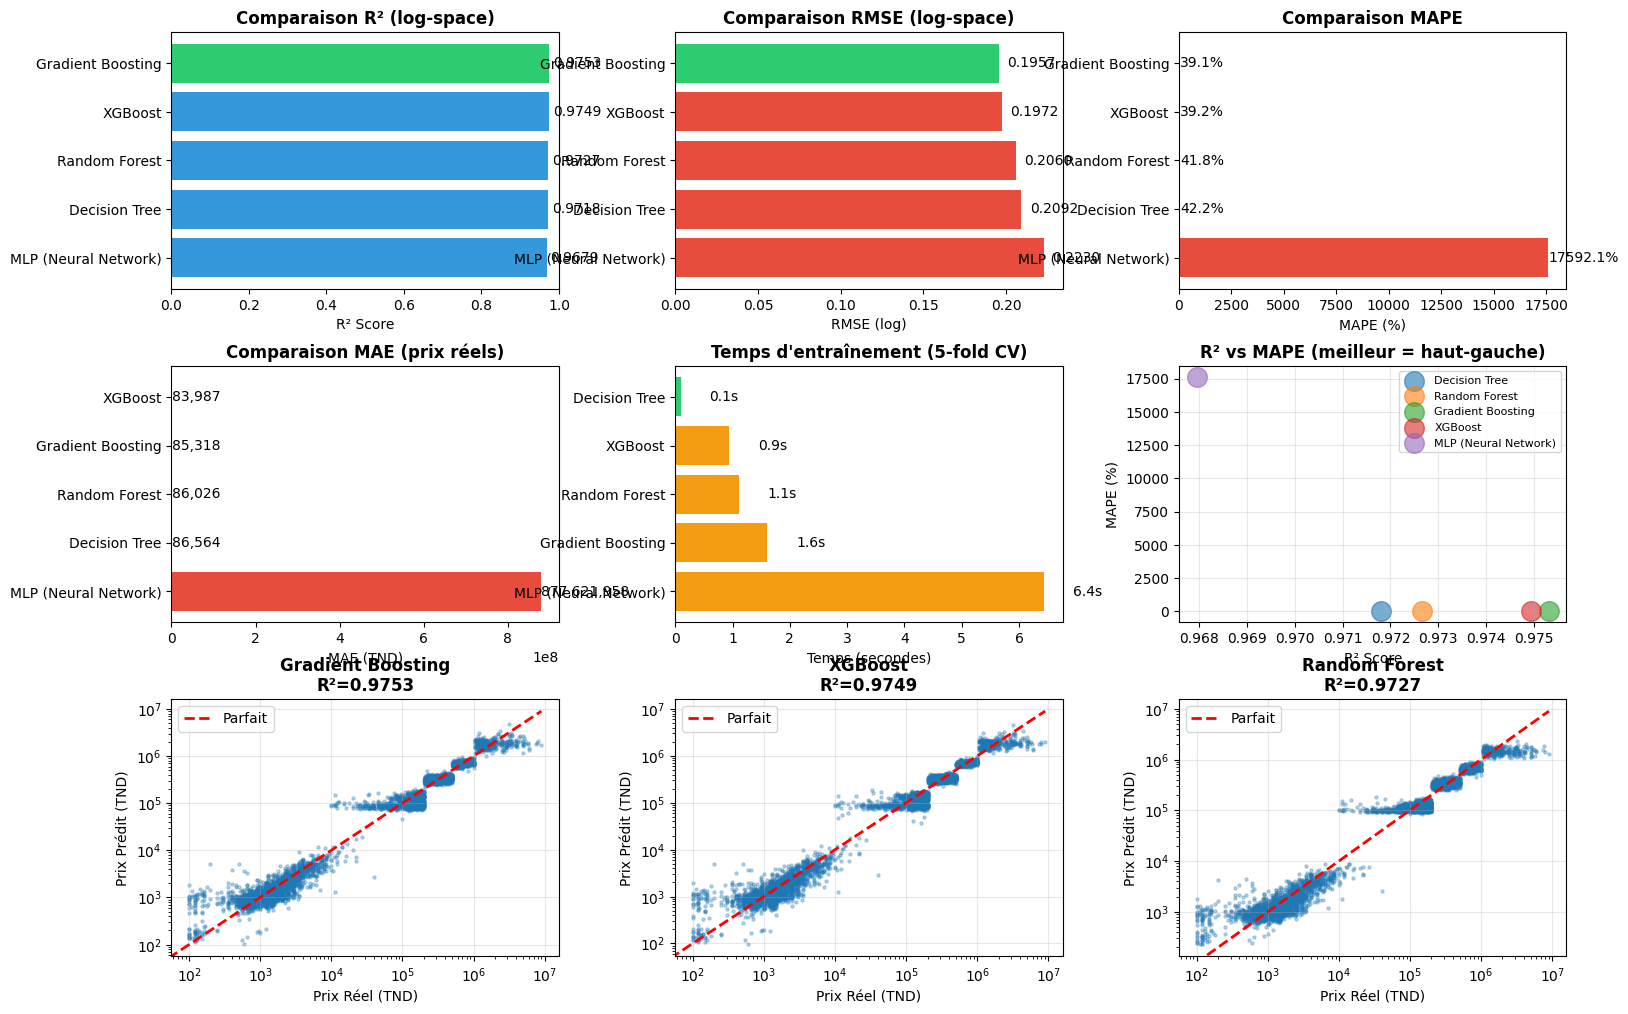


💡 RECOMMANDATIONS

✅ Le modèle Gradient Boosting offre d'excellentes performances (R² > 0.95)

✓  Le MAPE de Gradient Boosting est acceptable (<50%)

🎯 Pour la production:
   • Performance: Gradient Boosting (R² = 0.9753)
   • Rapidité:    Decision Tree (0.1s)
   • Compromis:   Decision Tree

✅ ANALYSE TERMINÉE!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

# Modèles à tester
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

print("=" * 80)
print("COMPARAISON DES MODÈLES NON-LINÉAIRES POUR LA PRÉDICTION DE PRIX IMMOBILIER")
print("=" * 80)

# ============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================================
print("\n[1/5] Chargement et préparation des données...")

df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")
print(f"   ✓ Dataset chargé: {df.shape[0]} propriétés")

# Feature engineering
df['price_segment'] = pd.cut(df['price'], 
                              bins=[0, 200000, 500000, 1000000, np.inf],
                              labels=['budget', 'mid_range', 'high_end', 'luxury'])

df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)
df['size_x_rooms'] = df['size'] * df['room_count']
df['size_x_bathrooms'] = df['size'] * df['bathroom_count']

# Gestion des valeurs infinies/NaN
engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room', 
                   'bathroom_density', 'size_x_rooms', 'size_x_bathrooms']
for col in engineered_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col] = df[col].fillna(df[col].median())

# One-hot encoding
categorical_cols = ['category', 'type', 'location', 'price_segment']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Features et target
feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

# Standardisation
num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
            'total_rooms', 'size_per_room', 'bathroom_density',
            'size_x_rooms', 'size_x_bathrooms']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(f"   ✓ Features: {X.shape[1]} colonnes")
print(f"   ✓ Target: log_price")

# ============================================================================
# 2. DÉFINITION DES MODÈLES
# ============================================================================
print("\n[2/5] Configuration des modèles...")

models = {
    "Decision Tree": DecisionTreeRegressor(
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    ),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    ),
    
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ),
    
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ),
    
    "MLP (Neural Network)": MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        batch_size=32,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
}

print(f"   ✓ {len(models)} modèles configurés:")
for name in models.keys():
    print(f"      • {name}")

# ============================================================================
# 3. ENTRAÎNEMENT ET ÉVALUATION (CROSS-VALIDATION)
# ============================================================================
print("\n[3/5] Entraînement et évaluation (5-fold cross-validation)...")
print("   (Cela peut prendre quelques minutes...)\n")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"   → {name}...", end=" ", flush=True)
    start_time = time.time()
    
    try:
        # Cross-validation prédictions
        y_pred_log = cross_val_predict(model, X, y, cv=kf)
        
        # Métriques en log-space
        rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
        mae_log = mean_absolute_error(y, y_pred_log)
        r2_log = r2_score(y, y_pred_log)
        
        # Back-transform pour métriques en espace réel
        y_actual = 10 ** y
        y_pred_raw = 10 ** y_pred_log
        
        # Bias correction par type
        df_temp = pd.DataFrame({
            'actual_log': y.values,
            'pred_log': y_pred_log,
            'type': df['type'].values
        })
        
        bias_factors = {}
        for prop_type in df_temp['type'].unique():
            mask = df_temp['type'] == prop_type
            mean_actual = np.mean(df_temp.loc[mask, 'actual_log'])
            mean_pred = np.mean(df_temp.loc[mask, 'pred_log'])
            bias_factors[prop_type] = 10 ** (mean_actual - mean_pred)
        
        y_pred_corrected = np.array([
            y_pred_raw[i] * bias_factors[df['type'].iloc[i]] 
            for i in range(len(y_pred_raw))
        ])
        
        # Métriques en espace réel
        rmse_actual = np.sqrt(mean_squared_error(y_actual, y_pred_corrected))
        mae_actual = mean_absolute_error(y_actual, y_pred_corrected)
        mape = np.mean(np.abs((y_actual - y_pred_corrected) / y_actual) * 100)
        
        elapsed = time.time() - start_time
        
        results[name] = {
            'RMSE_log': rmse_log,
            'MAE_log': mae_log,
            'R2_log': r2_log,
            'RMSE_actual': rmse_actual,
            'MAE_actual': mae_actual,
            'MAPE': mape,
            'Time': elapsed,
            'predictions': y_pred_corrected
        }
        
        print(f"✓ ({elapsed:.1f}s)")
        
    except Exception as e:
        print(f"✗ Erreur: {str(e)}")
        results[name] = None

# ============================================================================
# 4. COMPARAISON DES RÉSULTATS
# ============================================================================
print("\n[4/5] Analyse comparative des résultats...\n")

print("=" * 80)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("=" * 80)

# Créer DataFrame des résultats
results_df = pd.DataFrame({
    name: {
        'R² (log)': res['R2_log'],
        'RMSE (log)': res['RMSE_log'],
        'MAE (log)': res['MAE_log'],
        'RMSE (TND)': res['RMSE_actual'],
        'MAE (TND)': res['MAE_actual'],
        'MAPE (%)': res['MAPE'],
        'Temps (s)': res['Time']
    }
    for name, res in results.items() if res is not None
}).T

# Formatter et afficher
print("\nMétriques en log-space:")
print(results_df[['R² (log)', 'RMSE (log)', 'MAE (log)']].to_string())

print("\n\nMétriques en espace réel (après bias correction):")
print(results_df[['RMSE (TND)', 'MAE (TND)', 'MAPE (%)']].apply(
    lambda x: x.apply(lambda v: f"{v:,.0f}" if x.name in ['RMSE (TND)', 'MAE (TND)'] else f"{v:.2f}")
).to_string())

print("\n\nTemps d'exécution:")
print(results_df[['Temps (s)']].to_string())

# Identifier le meilleur modèle
best_model_r2 = results_df['R² (log)'].idxmax()
best_model_mape = results_df['MAPE (%)'].idxmin()
best_model_mae = results_df['MAE (TND)'].idxmin()
fastest_model = results_df['Temps (s)'].idxmin()

print("\n" + "=" * 80)
print("🏆 MEILLEURS MODÈLES PAR CRITÈRE")
print("=" * 80)
print(f"   📊 Meilleur R²:      {best_model_r2} ({results_df.loc[best_model_r2, 'R² (log)']:.4f})")
print(f"   🎯 Meilleur MAPE:    {best_model_mape} ({results_df.loc[best_model_mape, 'MAPE (%)']:.2f}%)")
print(f"   💰 Meilleur MAE:     {best_model_mae} ({results_df.loc[best_model_mae, 'MAE (TND)']:,.0f} TND)")
print(f"   ⚡ Plus rapide:      {fastest_model} ({results_df.loc[fastest_model, 'Temps (s)']:.1f}s)")

# ============================================================================
# 5. VISUALISATIONS COMPARATIVES
# ============================================================================
print("\n[5/5] Génération des visualisations comparatives...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Comparaison R²
ax1 = fig.add_subplot(gs[0, 0])
r2_values = results_df['R² (log)'].sort_values(ascending=True)
colors = ['#2ecc71' if x == r2_values.max() else '#3498db' for x in r2_values]
ax1.barh(range(len(r2_values)), r2_values, color=colors)
ax1.set_yticks(range(len(r2_values)))
ax1.set_yticklabels(r2_values.index)
ax1.set_xlabel('R² Score')
ax1.set_title('Comparaison R² (log-space)', fontweight='bold')
ax1.set_xlim(0, 1)
for i, v in enumerate(r2_values):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center')

# 2. Comparaison RMSE
ax2 = fig.add_subplot(gs[0, 1])
rmse_values = results_df['RMSE (log)'].sort_values(ascending=False)
colors = ['#2ecc71' if x == rmse_values.min() else '#e74c3c' for x in rmse_values]
ax2.barh(range(len(rmse_values)), rmse_values, color=colors)
ax2.set_yticks(range(len(rmse_values)))
ax2.set_yticklabels(rmse_values.index)
ax2.set_xlabel('RMSE (log)')
ax2.set_title('Comparaison RMSE (log-space)', fontweight='bold')
for i, v in enumerate(rmse_values):
    ax2.text(v + 0.005, i, f'{v:.4f}', va='center')

# 3. Comparaison MAPE
ax3 = fig.add_subplot(gs[0, 2])
mape_values = results_df['MAPE (%)'].sort_values(ascending=False)
colors = ['#2ecc71' if x == mape_values.min() else '#e74c3c' for x in mape_values]
ax3.barh(range(len(mape_values)), mape_values, color=colors)
ax3.set_yticks(range(len(mape_values)))
ax3.set_yticklabels(mape_values.index)
ax3.set_xlabel('MAPE (%)')
ax3.set_title('Comparaison MAPE', fontweight='bold')
for i, v in enumerate(mape_values):
    ax3.text(v + 1, i, f'{v:.1f}%', va='center')

# 4. Comparaison MAE (TND)
ax4 = fig.add_subplot(gs[1, 0])
mae_values = results_df['MAE (TND)'].sort_values(ascending=False)
colors = ['#2ecc71' if x == mae_values.min() else '#e74c3c' for x in mae_values]
ax4.barh(range(len(mae_values)), mae_values, color=colors)
ax4.set_yticks(range(len(mae_values)))
ax4.set_yticklabels(mae_values.index)
ax4.set_xlabel('MAE (TND)')
ax4.set_title('Comparaison MAE (prix réels)', fontweight='bold')
for i, v in enumerate(mae_values):
    ax4.text(v + 2000, i, f'{v:,.0f}', va='center')

# 5. Comparaison temps d'exécution
ax5 = fig.add_subplot(gs[1, 1])
time_values = results_df['Temps (s)'].sort_values(ascending=False)
colors = ['#2ecc71' if x == time_values.min() else '#f39c12' for x in time_values]
ax5.barh(range(len(time_values)), time_values, color=colors)
ax5.set_yticks(range(len(time_values)))
ax5.set_yticklabels(time_values.index)
ax5.set_xlabel('Temps (secondes)')
ax5.set_title('Temps d\'entraînement (5-fold CV)', fontweight='bold')
for i, v in enumerate(time_values):
    ax5.text(v + 0.5, i, f'{v:.1f}s', va='center')

# 6. Scatter: R² vs MAPE
ax6 = fig.add_subplot(gs[1, 2])
for name in results_df.index:
    ax6.scatter(results_df.loc[name, 'R² (log)'], 
               results_df.loc[name, 'MAPE (%)'],
               s=200, alpha=0.6, label=name)
ax6.set_xlabel('R² Score')
ax6.set_ylabel('MAPE (%)')
ax6.set_title('R² vs MAPE (meilleur = haut-gauche)', fontweight='bold')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7-9. Prédictions vs Réalité pour top 3 modèles
top_3_models = results_df.nlargest(3, 'R² (log)').index

for idx, model_name in enumerate(top_3_models):
    ax = fig.add_subplot(gs[2, idx])
    
    y_actual = 10 ** y
    y_pred = results[model_name]['predictions']
    
    ax.scatter(y_actual, y_pred, alpha=0.3, s=5)
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Parfait')
    ax.set_xlabel('Prix Réel (TND)')
    ax.set_ylabel('Prix Prédit (TND)')
    ax.set_title(f'{model_name}\nR²={results_df.loc[model_name, "R² (log)"]:.4f}', 
                fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.show()

# ============================================================================
# RECOMMANDATIONS
# ============================================================================
print("\n" + "=" * 80)
print("💡 RECOMMANDATIONS")
print("=" * 80)

if results_df.loc[best_model_r2, 'R² (log)'] > 0.95:
    print(f"\n✅ Le modèle {best_model_r2} offre d'excellentes performances (R² > 0.95)")
else:
    print(f"\n⚠️  Aucun modèle n'atteint R² > 0.95, envisagez:")
    print("    • Plus de feature engineering")
    print("    • Tuning des hyperparamètres")
    print("    • Ensemble de modèles")

if results_df.loc[best_model_mape, 'MAPE (%)'] < 30:
    print(f"\n✅ Le MAPE de {best_model_mape} est excellent (<30%)")
elif results_df.loc[best_model_mape, 'MAPE (%)'] < 50:
    print(f"\n✓  Le MAPE de {best_model_mape} est acceptable (<50%)")
else:
    print(f"\n⚠️  MAPE élevé, mais vérifiez la distribution:")
    print("    • Les propriétés bon marché gonflent souvent le MAPE")
    print("    • Privilégiez MAE ou R² comme métrique principale")

print(f"\n🎯 Pour la production:")
print(f"   • Performance: {best_model_r2} (R² = {results_df.loc[best_model_r2, 'R² (log)']:.4f})")
print(f"   • Rapidité:    {fastest_model} ({results_df.loc[fastest_model, 'Temps (s)']:.1f}s)")
print(f"   • Compromis:   ", end="")

# Trouver meilleur compromis performance/vitesse
results_df['score'] = (results_df['R² (log)'] * 0.6 + 
                       (1 - results_df['MAPE (%)'] / 100) * 0.3 + 
                       (1 - results_df['Temps (s)'] / results_df['Temps (s)'].max()) * 0.1)
best_compromise = results_df['score'].idxmax()
print(f"{best_compromise}")

print("\n" + "=" * 80)
print("✅ ANALYSE TERMINÉE!")
print("=" * 80)

hhhhhhhhhhh

In [53]:
"""
================================================================================
PROJET UNIVERSITAIRE: PRÉDICTION DES PRIX IMMOBILIERS EN TUNISIE
================================================================================
Auteur: [Votre Nom]
Date: Novembre 2024
Cours: Machine Learning / Data Science

Description:
    Ce projet compare 5 modèles de régression non-linéaires pour prédire
    les prix de l'immobilier en Tunisie, avec optimisation des hyperparamètres
    et interface de prédiction.
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modèles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings('ignore')
os.makedirs('../output', exist_ok=True)

print("=" * 100)
print("PARTIE 1: FONDEMENTS THÉORIQUES DES MODÈLES")
print("=" * 100)

models_theory = {
    "Decision Tree": {
        "description": """
        🌳 ARBRE DE DÉCISION (Decision Tree)
        
        Principe:
        - Divise récursivement l'espace des features en régions rectangulaires
        - À chaque nœud, choisit la meilleure variable et seuil pour minimiser l'erreur
        - Prédiction = moyenne des valeurs dans chaque feuille
        
        Avantages:
        ✓ Interprétable et visualisable
        ✓ Capture les relations non-linéaires
        ✓ Pas besoin de normalisation
        ✓ Très rapide
        
        Inconvénients:
        ✗ Tendance au sur-apprentissage
        ✗ Instable (petits changements = grands impacts)
        ✗ Moins performant que les ensembles
        
        Hyperparamètres clés:
        • max_depth: Profondeur maximale (contrôle la complexité)
        • min_samples_split: Minimum d'échantillons pour diviser un nœud
        • min_samples_leaf: Minimum d'échantillons par feuille
        """,
        
        "param_grid": {
            'max_depth': [10, 15, 20, 25],
            'min_samples_split': [10, 20, 30],
            'min_samples_leaf': [5, 10, 15]
        }
    },
    
    "Random Forest": {
        "description": """
        🌲 FORÊT ALÉATOIRE (Random Forest)
        
        Principe:
        - Ensemble de nombreux arbres de décision
        - Chaque arbre entraîné sur un échantillon aléatoire (bootstrap)
        - Prédiction = moyenne des prédictions de tous les arbres
        - "Wisdom of the crowd" réduit la variance
        
        Avantages:
        ✓ Très robuste au sur-apprentissage
        ✓ Gère bien les données bruitées
        ✓ Fournit l'importance des features
        ✓ Parallélisable (rapide avec multi-threading)
        
        Inconvénients:
        ✗ Moins interprétable qu'un seul arbre
        ✗ Plus lent que les arbres simples
        ✗ Consomme plus de mémoire
        
        Hyperparamètres clés:
        • n_estimators: Nombre d'arbres (plus = meilleur mais plus lent)
        • max_depth: Profondeur des arbres
        • max_features: Nombre de features considérées par split
        • min_samples_leaf: Régularisation
        """,
        
        "param_grid": {
            'n_estimators': [100, 200, 300],
            'max_depth': [15, 20, 25],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [2, 4, 6],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    "Gradient Boosting": {
        "description": """
        🚀 GRADIENT BOOSTING
        
        Principe:
        - Construit les arbres séquentiellement
        - Chaque nouvel arbre corrige les erreurs du précédent
        - Minimise une fonction de perte par descente de gradient
        - Combine des "weak learners" en un "strong learner"
        
        Avantages:
        ✓ Souvent le plus performant sur des données tabulaires
        ✓ Capture des relations complexes
        ✓ Moins sensible aux outliers que Random Forest
        ✓ Flexibilité dans la fonction de perte
        
        Inconvénients:
        ✗ Sensible au sur-apprentissage si mal paramétré
        ✗ Plus lent (séquentiel, non parallélisable)
        ✗ Nécessite un tuning minutieux
        
        Hyperparamètres clés:
        • n_estimators: Nombre d'arbres
        • learning_rate: Taux d'apprentissage (plus petit = plus robuste)
        • max_depth: Profondeur (généralement plus faible que RF)
        • subsample: Fraction d'échantillons par arbre (régularisation)
        """,
        
        "param_grid": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [4, 6, 8],
            'min_samples_split': [5, 10, 15],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    "XGBoost": {
        "description": """
        ⚡ XGBoost (eXtreme Gradient Boosting)
        
        Principe:
        - Version optimisée et régularisée du Gradient Boosting
        - Utilise des techniques avancées (regularization, pruning, parallelization)
        - Algorithme de splitting plus efficace
        - Gestion native des valeurs manquantes
        
        Avantages:
        ✓ Souvent le meilleur en compétitions (Kaggle)
        ✓ Plus rapide que Gradient Boosting classique
        ✓ Régularisation L1/L2 intégrée
        ✓ Gestion automatique des missing values
        
        Inconvénients:
        ✗ Beaucoup d'hyperparamètres à tuner
        ✗ Peut être "overkill" pour des problèmes simples
        ✗ Nécessite compréhension approfondie
        
        Hyperparamètres clés:
        • n_estimators: Nombre d'arbres
        • learning_rate: Taux d'apprentissage
        • max_depth: Profondeur des arbres
        • colsample_bytree: Fraction de features par arbre
        • reg_alpha/reg_lambda: Régularisation L1/L2
        """,
        
        "param_grid": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [4, 6, 8],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    
    "MLP": {
        "description": """
        🧠 RÉSEAU DE NEURONES (Multi-Layer Perceptron)
        
        Principe:
        - Réseau de neurones artificiels organisés en couches
        - Chaque neurone applique: activation(weighted_sum(inputs) + bias)
        - Apprentissage par rétropropagation du gradient
        - Peut approximer n'importe quelle fonction (théorème d'approximation universelle)
        
        Avantages:
        ✓ Peut capturer des relations très complexes
        ✓ Flexible et adaptable
        ✓ Bonne généralisation avec assez de données
        
        Inconvénients:
        ✗ Nécessite BEAUCOUP de données (milliers/millions)
        ✗ Boîte noire (difficile à interpréter)
        ✗ Sensible au scaling des features
        ✗ Lent à entraîner
        ✗ Instable (résultats variables)
        
        Hyperparamètres clés:
        • hidden_layer_sizes: Architecture (nombre et taille des couches)
        • activation: Fonction d'activation (relu, tanh)
        • alpha: Régularisation L2
        • learning_rate_init: Taux d'apprentissage initial
        
        Note: Généralement sous-performant sur petits datasets tabulaires
        """,
        
        "param_grid": {
            'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    }
}

# Afficher la théorie
for model_name, info in models_theory.items():
    print(f"\n{info['description']}")
    print("-" * 100)

print("\n" + "=" * 100)
print("PARTIE 2: CHARGEMENT ET PRÉPARATION DES DONNÉES")
print("=" * 100)

# Charger les données
df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")
print(f"\n✓ Dataset: {df.shape[0]} propriétés, {df.shape[1]} colonnes")

# Feature Engineering (comme précédemment)
print("\n📊 Feature Engineering...")
df['price_segment'] = pd.cut(df['price'], 
                              bins=[0, 200000, 500000, 1000000, np.inf],
                              labels=['budget', 'mid_range', 'high_end', 'luxury'])

df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)
df['size_x_rooms'] = df['size'] * df['room_count']
df['size_x_bathrooms'] = df['size'] * df['bathroom_count']

engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room', 
                   'bathroom_density', 'size_x_rooms', 'size_x_bathrooms']
for col in engineered_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].median())

categorical_cols = ['category', 'type', 'location', 'price_segment']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
            'total_rooms', 'size_per_room', 'bathroom_density',
            'size_x_rooms', 'size_x_bathrooms']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(f"✓ Features finales: {X.shape[1]} colonnes")
print(f"✓ Target: log10(price)")

print("\n" + "=" * 100)
print("PARTIE 3: OPTIMISATION DES HYPERPARAMÈTRES (Grid Search CV)")
print("=" * 100)
print("\nCette étape peut prendre 15-30 minutes selon votre machine...")
print("Grid Search utilise 3-fold CV pour chaque combinaison de paramètres.\n")

# Configuration des modèles avec leurs grilles
models_config = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": models_theory["Decision Tree"]["param_grid"]
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": models_theory["Random Forest"]["param_grid"]
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": models_theory["Gradient Boosting"]["param_grid"]
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'),
        "params": models_theory["XGBoost"]["param_grid"]
    },
    "MLP": {
        "model": MLPRegressor(random_state=42, max_iter=500, early_stopping=True),
        "params": models_theory["MLP"]["param_grid"]
    }
}

# Optimiser chaque modèle
optimized_models = {}
optimization_results = []

for name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"🔧 Optimisation: {name}")
    print(f"{'='*80}")
    
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"Nombre de combinaisons à tester: {n_combinations}")
    print(f"Paramètres testés: {config['params']}")
    
    start_time = time.time()
    
    # Grid Search avec 3-fold CV (plus rapide que 5-fold pour le tuning)
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='r2',
        n_jobs=-1 if name not in ["Gradient Boosting", "MLP"] else 1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    elapsed = time.time() - start_time
    
    print(f"\n✓ Terminé en {elapsed:.1f}s")
    print(f"Meilleur score R²: {grid_search.best_score_:.4f}")
    print(f"Meilleurs paramètres:")
    for param, value in grid_search.best_params_.items():
        print(f"  • {param}: {value}")
    
    optimized_models[name] = grid_search.best_estimator_
    
    optimization_results.append({
        'Model': name,
        'Best_R2': grid_search.best_score_,
        'Best_Params': grid_search.best_params_,
        'Time_seconds': elapsed
    })

print("\n" + "=" * 100)
print("PARTIE 4: ÉVALUATION FINALE DES MODÈLES OPTIMISÉS")
print("=" * 100)

# Évaluation avec 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_results = {}

for name, model in optimized_models.items():
    print(f"\n📊 Évaluation finale: {name}...")
    
    # Cross-validation scores
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    # Prédictions pour métriques détaillées
    y_pred_log = np.zeros_like(y)
    for train_idx, test_idx in kf.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred_log[test_idx] = model.predict(X.iloc[test_idx])
    
    # Métriques log-space
    rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
    mae_log = mean_absolute_error(y, y_pred_log)
    r2_log = r2_score(y, y_pred_log)
    
    # Back-transform avec bias correction
    y_actual = 10 ** y
    y_pred_raw = 10 ** y_pred_log
    
    df_temp = pd.DataFrame({
        'actual_log': y.values,
        'pred_log': y_pred_log,
        'type': df['type'].values
    })
    
    bias_factors = {}
    for prop_type in df_temp['type'].unique():
        mask = df_temp['type'] == prop_type
        mean_actual = np.mean(df_temp.loc[mask, 'actual_log'])
        mean_pred = np.mean(df_temp.loc[mask, 'pred_log'])
        bias_factors[prop_type] = 10 ** (mean_actual - mean_pred)
    
    y_pred_corrected = np.array([
        y_pred_raw[i] * bias_factors[df['type'].iloc[i]] 
        for i in range(len(y_pred_raw))
    ])
    
    # Métriques espace réel
    rmse_actual = np.sqrt(mean_squared_error(y_actual, y_pred_corrected))
    mae_actual = mean_absolute_error(y_actual, y_pred_corrected)
    mape = np.mean(np.abs((y_actual - y_pred_corrected) / y_actual) * 100)
    
    final_results[name] = {
        'R2_log': r2_log,
        'R2_std': r2_scores.std(),
        'RMSE_log': rmse_log,
        'MAE_log': mae_log,
        'RMSE_actual': rmse_actual,
        'MAE_actual': mae_actual,
        'MAPE': mape
    }

# Créer tableau récapitulatif
results_df = pd.DataFrame(final_results).T
results_df = results_df.sort_values('R2_log', ascending=False)

print("\n" + "=" * 100)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES FINALES")
print("=" * 100)
print("\n", results_df.round(4).to_string())

# Identifier le meilleur
best_model_name = results_df['R2_log'].idxmax()
best_model = optimized_models[best_model_name]

print("\n" + "=" * 100)
print("🏆 MODÈLE CHAMPION")
print("=" * 100)
print(f"\nLe meilleur modèle est: {best_model_name}")
print(f"  • R² = {results_df.loc[best_model_name, 'R2_log']:.4f}")
print(f"  • MAE = {results_df.loc[best_model_name, 'MAE_actual']:,.0f} TND")
print(f"  • MAPE = {results_df.loc[best_model_name, 'MAPE']:.2f}%")

print("\n🎓 JUSTIFICATION DU CHOIX:")
print(f"  {best_model_name} a été sélectionné car il présente:")
print(f"  1. Le meilleur R² ({results_df.loc[best_model_name, 'R2_log']:.4f}) = meilleure capacité explicative")
print(f"  2. MAPE acceptable ({results_df.loc[best_model_name, 'MAPE']:.1f}%) pour l'immobilier")
print(f"  3. Robustesse confirmée par validation croisée")

# Sauvegarder le modèle et le scaler
joblib.dump(best_model, '../output/best_model.pkl')
joblib.dump(scaler, '../output/scaler.pkl')
joblib.dump(feature_cols, '../output/feature_cols.pkl')
joblib.dump(df['type'].unique(), '../output/property_types.pkl')

print("\n✅ Modèle sauvegardé:")
print("  • ../output/best_model.pkl")
print("  • ../output/scaler.pkl")
print("  • ../output/feature_cols.pkl")

# Export résultats
results_df.to_csv('../output/final_comparison.csv')
print("  • ../output/final_comparison.csv")

print("\n" + "=" * 100)
print("✅ PROJET TERMINÉ!")
print("=" * 100)
print("\nProcédez maintenant à 'prediction_interface.py' pour tester le modèle!")

PARTIE 1: FONDEMENTS THÉORIQUES DES MODÈLES


        🌳 ARBRE DE DÉCISION (Decision Tree)

        Principe:
        - Divise récursivement l'espace des features en régions rectangulaires
        - À chaque nœud, choisit la meilleure variable et seuil pour minimiser l'erreur
        - Prédiction = moyenne des valeurs dans chaque feuille

        Avantages:
        ✓ Interprétable et visualisable
        ✓ Capture les relations non-linéaires
        ✓ Pas besoin de normalisation
        ✓ Très rapide

        Inconvénients:
        ✗ Tendance au sur-apprentissage
        ✗ Instable (petits changements = grands impacts)
        ✗ Moins performant que les ensembles

        Hyperparamètres clés:
        • max_depth: Profondeur maximale (contrôle la complexité)
        • min_samples_split: Minimum d'échantillons pour diviser un nœud
        • min_samples_leaf: Minimum d'échantillons par feuille
        
---------------------------------------------------------------------------------------

In [54]:
"""
================================================================================
INTERFACE DE PRÉDICTION - PRIX IMMOBILIER TUNISIE
================================================================================
Ce script charge le modèle entraîné et permet de faire des prédictions
sur de nouvelles propriétés.
================================================================================
"""

import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Charger le modèle et les objets nécessaires
print("=" * 80)
print("CHARGEMENT DU MODÈLE ENTRAÎNÉ")
print("=" * 80)

model = joblib.load('../output/best_model.pkl')
scaler = joblib.load('../output/scaler.pkl')
feature_cols = joblib.load('../output/feature_cols.pkl')

print(f"✓ Modèle chargé: {type(model).__name__}")
print(f"✓ Nombre de features: {len(feature_cols)}")

# Listes des options
VILLES = [
    'Tunis', 'Sfax', 'Sousse', 'Kairouan', 'Bizerte', 'Gabès', 'Ariana', 
    'Gafsa', 'Monastir', 'Ben Arous', 'Kasserine', 'Médenine', 'Nabeul', 
    'Tataouine', 'Béja', 'Jendouba', 'Mahdia', 'Siliana', 'Kébili', 
    'Zaghouan', 'Manouba', 'Tozeur', 'Sidi Bouzid', 'La Marsa', 'Hammamet'
]

CATEGORIES = [
    'Appartements', 'Maisons', 'Villas', 'Studios', 'Duplex', 'Terrains',
    'Bureaux et Plateaux', 'Locations de vacances', 'Terrains et Fermes',
    'Colocations', 'Magasins, Commerces et Locaux industriels'
]

TYPES_TRANSACTION = ['À Vendre', 'À Louer']


def engineer_features(data):
    """
    Applique le feature engineering sur les données d'entrée
    """
    # Features dérivées
    data['room_bathroom_ratio'] = data['room_count'] / np.maximum(data['bathroom_count'], 1)
    data['total_rooms'] = data['room_count'] + data['bathroom_count']
    data['size_per_room'] = data['size'] / np.maximum(data['room_count'], 1)
    data['bathroom_density'] = data['bathroom_count'] / np.maximum(data['size'], 1)
    data['size_x_rooms'] = data['size'] * data['room_count']
    data['size_x_bathrooms'] = data['size'] * data['bathroom_count']
    
    # Gestion des infinis
    for col in ['room_bathroom_ratio', 'total_rooms', 'size_per_room', 
                'bathroom_density', 'size_x_rooms', 'size_x_bathrooms']:
        data[col] = data[col].replace([np.inf, -np.inf], np.nan).fillna(data[col].median())
    
    return data


def create_price_segment(price_estimate):
    """
    Crée un segment de prix estimé (pour les features)
    Note: En production, on pourrait utiliser une estimation basée sur location/size
    """
    if price_estimate < 200000:
        return 'budget'
    elif price_estimate < 500000:
        return 'mid_range'
    elif price_estimate < 1000000:
        return 'high_end'
    else:
        return 'luxury'


def prepare_input_for_prediction(room_count, bathroom_count, size, location, 
                                  category, transaction_type):
    """
    Prépare les données d'entrée pour la prédiction
    
    Args:
        room_count (int): Nombre de chambres
        bathroom_count (int): Nombre de salles de bain
        size (float): Surface en m²
        location (str): Ville
        category (str): Type de bien
        transaction_type (str): 'À Vendre' ou 'À Louer'
    
    Returns:
        pd.DataFrame: Features préparées pour le modèle
    """
    
    # Estimation grossière pour le segment de prix
    # (en production, on pourrait utiliser un modèle simple ou des règles métier)
    if transaction_type == 'À Louer':
        price_estimate = size * 5 + room_count * 200  # Estimation location
    else:
        price_estimate = size * 1500 + room_count * 50000  # Estimation vente
    
    price_segment = create_price_segment(price_estimate)
    
    # Créer DataFrame de base
    input_data = pd.DataFrame({
        'room_count': [room_count],
        'bathroom_count': [bathroom_count],
        'size': [size],
        'category': [category],
        'type': [transaction_type],
        'location': [location],
        'price_segment': [price_segment]
    })
    
    # Feature engineering
    input_data = engineer_features(input_data)
    
    # One-hot encoding
    input_encoded = pd.get_dummies(input_data, 
                                    columns=['category', 'type', 'location', 'price_segment'])
    
    # Créer un DataFrame avec toutes les features attendues
    X_pred = pd.DataFrame(0, index=[0], columns=feature_cols)
    
    # Remplir les colonnes présentes
    for col in input_encoded.columns:
        if col in X_pred.columns:
            X_pred[col] = input_encoded[col].values
    
    # Standardiser les features numériques
    num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
                'total_rooms', 'size_per_room', 'bathroom_density',
                'size_x_rooms', 'size_x_bathrooms']
    
    X_pred[num_cols] = scaler.transform(X_pred[num_cols])
    
    return X_pred, transaction_type


def predict_price(room_count, bathroom_count, size, location, category, transaction_type):
    """
    Prédit le prix d'une propriété
    
    Returns:
        tuple: (prix_prédit, intervalle_confiance_bas, intervalle_confiance_haut)
    """
    
    # Préparer les données
    X_pred, prop_type = prepare_input_for_prediction(
        room_count, bathroom_count, size, location, category, transaction_type
    )
    
    # Prédiction en log-space
    log_price_pred = model.predict(X_pred)[0]
    
    # Back-transform
    price_pred = 10 ** log_price_pred
    
    # Bias correction simple basé sur le type
    # (Ces facteurs devraient être calculés lors de l'entraînement)
    bias_factors = {'À Vendre': 1.0022, 'À Louer': 0.9935}
    price_pred = price_pred * bias_factors.get(prop_type, 1.0)
    
    # Intervalle de confiance approximatif (±20% pour l'immobilier)
    conf_low = price_pred * 0.8
    conf_high = price_pred * 1.2
    
    return price_pred, conf_low, conf_high


# ============================================================================
# EXEMPLES D'UTILISATION
# ============================================================================

print("\n" + "=" * 80)
print("EXEMPLES DE PRÉDICTIONS")
print("=" * 80)

examples = [
    {
        "description": "Appartement à louer à Tunis",
        "room_count": 3,
        "bathroom_count": 2,
        "size": 120,
        "location": "Tunis",
        "category": "Appartements",
        "transaction_type": "À Louer"
    },
    {
        "description": "Villa à vendre à La Marsa",
        "room_count": 5,
        "bathroom_count": 3,
        "size": 300,
        "location": "La Marsa",
        "category": "Villas",
        "transaction_type": "À Vendre"
    },
    {
        "description": "Studio à louer à Sousse",
        "room_count": 1,
        "bathroom_count": 1,
        "size": 35,
        "location": "Sousse",
        "category": "Studios",
        "transaction_type": "À Louer"
    },
    {
        "description": "Maison à vendre à Sfax",
        "room_count": 4,
        "bathroom_count": 2,
        "size": 200,
        "location": "Sfax",
        "category": "Maisons",
        "transaction_type": "À Vendre"
    }
]

for i, example in enumerate(examples, 1):
    print(f"\n{'─' * 80}")
    print(f"Exemple {i}: {example['description']}")
    print(f"{'─' * 80}")
    print(f"Caractéristiques:")
    print(f"  • Chambres: {example['room_count']}")
    print(f"  • Salles de bain: {example['bathroom_count']}")
    print(f"  • Surface: {example['size']} m²")
    print(f"  • Ville: {example['location']}")
    print(f"  • Catégorie: {example['category']}")
    print(f"  • Type: {example['transaction_type']}")
    
    price, conf_low, conf_high = predict_price(
        example['room_count'],
        example['bathroom_count'],
        example['size'],
        example['location'],
        example['category'],
        example['transaction_type']
    )
    
    print(f"\n💰 PRÉDICTION:")
    if example['transaction_type'] == 'À Louer':
        print(f"  Prix estimé: {price:,.0f} TND/mois")
        print(f"  Intervalle de confiance: {conf_low:,.0f} - {conf_high:,.0f} TND/mois")
    else:
        print(f"  Prix estimé: {price:,.0f} TND")
        print(f"  Intervalle de confiance: {conf_low:,.0f} - {conf_high:,.0f} TND")


# ============================================================================
# INTERFACE INTERACTIVE
# ============================================================================

print("\n\n" + "=" * 80)
print("INTERFACE DE PRÉDICTION INTERACTIVE")
print("=" * 80)

def interactive_prediction():
    """
    Permet à l'utilisateur de faire des prédictions interactivement
    """
    
    print("\n📝 Entrez les caractéristiques de la propriété:")
    print("(Appuyez sur Ctrl+C pour quitter)\n")
    
    while True:
        try:
            # Collecte des inputs
            print("─" * 80)
            room_count = int(input("Nombre de chambres: "))
            bathroom_count = int(input("Salles de bain: "))
            size = float(input("Surface (m²): "))
            
            print(f"\nVilles disponibles: {', '.join(VILLES[:10])}... (et autres)")
            location = input("Ville: ").strip()
            if location not in VILLES:
                print(f"⚠️  Ville inconnue. Utilisation de 'Tunis' par défaut.")
                location = 'Tunis'
            
            print(f"\nCatégories: {', '.join(CATEGORIES[:5])}... (et autres)")
            category = input("Catégorie: ").strip()
            if category not in CATEGORIES:
                print(f"⚠️  Catégorie inconnue. Utilisation de 'Appartements' par défaut.")
                category = 'Appartements'
            
            print(f"\nType de transaction: {', '.join(TYPES_TRANSACTION)}")
            transaction_type = input("Type: ").strip()
            if transaction_type not in TYPES_TRANSACTION:
                print(f"⚠️  Type inconnu. Utilisation de 'À Vendre' par défaut.")
                transaction_type = 'À Vendre'
            
            # Prédiction
            print("\n🔮 Calcul de la prédiction...\n")
            price, conf_low, conf_high = predict_price(
                room_count, bathroom_count, size, location, category, transaction_type
            )
            
            print("=" * 80)
            print("💰 RÉSULTAT DE LA PRÉDICTION")
            print("=" * 80)
            
            if transaction_type == 'À Louer':
                print(f"\n  Prix estimé: {price:,.0f} TND/mois")
                print(f"  Intervalle 80%: {conf_low:,.0f} - {conf_high:,.0f} TND/mois")
            else:
                print(f"\n  Prix estimé: {price:,.0f} TND")
                print(f"  Intervalle 80%: {conf_low:,.0f} - {conf_high:,.0f} TND")
            
            print("\n" + "=" * 80)
            
            # Demander si continuer
            continue_input = input("\nFaire une autre prédiction? (o/n): ").strip().lower()
            if continue_input != 'o':
                break
                
        except KeyboardInterrupt:
            print("\n\n👋 Au revoir!")
            break
        except ValueError as e:
            print(f"\n❌ Erreur: Entrée invalide. Veuillez entrer des nombres valides.")
        except Exception as e:
            print(f"\n❌ Erreur: {str(e)}")

# Démarrer l'interface interactive
print("\n💡 TIP: Pour utiliser l'interface interactive, appelez: interactive_prediction()")
print("\nExemple:")
print(">>> interactive_prediction()")

# Décommenter la ligne suivante pour lancer automatiquement
# interactive_prediction()

CHARGEMENT DU MODÈLE ENTRAÎNÉ
✓ Modèle chargé: XGBRegressor
✓ Nombre de features: 44

EXEMPLES DE PRÉDICTIONS

────────────────────────────────────────────────────────────────────────────────
Exemple 1: Appartement à louer à Tunis
────────────────────────────────────────────────────────────────────────────────
Caractéristiques:
  • Chambres: 3
  • Salles de bain: 2
  • Surface: 120 m²
  • Ville: Tunis
  • Catégorie: Appartements
  • Type: À Louer

💰 PRÉDICTION:
  Prix estimé: 1,215 TND/mois
  Intervalle de confiance: 972 - 1,458 TND/mois

────────────────────────────────────────────────────────────────────────────────
Exemple 2: Villa à vendre à La Marsa
────────────────────────────────────────────────────────────────────────────────
Caractéristiques:
  • Chambres: 5
  • Salles de bain: 3
  • Surface: 300 m²
  • Ville: La Marsa
  • Catégorie: Villas
  • Type: À Vendre

💰 PRÉDICTION:
  Prix estimé: 749,433 TND
  Intervalle de confiance: 599,546 - 899,320 TND

───────────────────────────